# Detecting Continuous Gravitational Waves

In [61]:
import pandas as pd

import torch
from torch import nn
from torch.optim import Adam, AdamW
from torch.utils.data import Dataset, random_split

import timm
import albumentations as A
from albumentations.pytorch import ToTensorV2

from skorch import NeuralNetClassifier
from skorch.callbacks import ProgressBar, Checkpoint, LRScheduler, EpochScoring
from skorch.helper import predefined_split

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, average_precision_score, confusion_matrix, roc_curve, precision_recall_curve, make_scorer, brier_score_loss, recall_score, precision_score

import h5py
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from os import walk
from multiprocessing import Pool

In [62]:
%matplotlib inline
plt.style.use('grayscale')

In [63]:
NUM_WORKERS = 4
NUM_EPOCHS = 10
BATCH_SIZE = 2
LEARNING_RATE = 1e-5
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [64]:
RANDOM_STATE = 177013
torch.manual_seed(RANDOM_STATE)
torch.cuda.manual_seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
torch.backends.cudnn.benchmark = True

In [65]:
MAX_LENGTH=4200

In [66]:
df = pd.read_csv('/kaggle/input/g2net-detecting-continuous-gravitational-waves/train_labels.csv')

In [67]:
labels = dict(df.values)

In [68]:
df['target'].value_counts()

 1    400
 0    200
-1      3
Name: target, dtype: int64

The -1 labels are a sort of an inside joke so we'll be omitting those.

In [69]:
exclusions = df[df['target'] == -1]['id'].to_list()

## Preparing the dataset

In [70]:
train_dir = '/kaggle/input/g2net-detecting-continuous-gravitational-waves/train/'
test_dir = '/kaggle/input/g2net-detecting-continuous-gravitational-waves/test'

In [71]:
def normalize(wave):
    return wave / 3.488688e-20

In [73]:
class Transforms:
    def __init__(self, sequence):
        self.transforms = sequence

    def __call__(self, img, *args, **kwargs):
        return self.transforms(image=np.array(img))['image']

transformations = Transforms(A.Compose([
	A.Rotate(10, interpolation=0),
	A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ColorJitter(),
	ToTensorV2(),
]))

inference_transformations = Transforms(A.Compose([
	ToTensorV2(),
]))

In [74]:
def read_hdf(path):
    data = []
    with h5py.File(path, "r") as f:
        for file_key in f.keys():
            group = f[file_key]
            if isinstance(group, h5py._hl.dataset.Dataset):
                data.append(np.array(group))
                continue
            for group_key in group.keys():
                group2 = group[group_key]
                if isinstance(group2, h5py._hl.dataset.Dataset):
                    data.append(np.array(group2))
                    continue
                for group_key2 in group2.keys():
                    group3 = group2[group_key2]
                    if isinstance(group3, h5py._hl.dataset.Dataset):
                        data.append(np.array(group3))
                        continue
    
    ch1 = torch.from_numpy(normalize(data[0][:,:MAX_LENGTH]))
    ch2 = torch.from_numpy(normalize(data[2][:,:MAX_LENGTH]))

    chunk = torch.stack((ch1, ch2))
    
    return chunk

In [75]:
def powernorm(spec):
    ch1 = torch.abs(spec[0]) ** 2
    ch2 = torch.abs(spec[1]) ** 2

    ch1 = (ch1 - ch1.mean()) / ch1.mean()
    ch2 = (ch2 - ch2.mean()) / ch2.mean()
    
    return ch1, ch2

In [76]:
def compr(ch, augment=False):
    result = ch.reshape(360, 56, 75).mean(dim=2)
    return result

In [77]:
class HDFHotSwap(torch.utils.data.Dataset):
    '''
    Dynamically loads HDF5 files from every subdir.
    '''
    @staticmethod
    def process_file(file):
        '''
        Extracts the observation id from filename.
        '''
        observation_id = file[:-5]
        return observation_id

    def __init__(self, folder, labels, augment=False):
        '''
        Accepts the folder and labels dict, and whether to use augmentations.
        '''
        self.root = folder
        self.files = []
        self.augment = augment
        # build a list of files:
        pool = Pool(NUM_WORKERS)
        for subdir, dirs, files in walk(self.root):
            results = pool.map(HDFHotSwap.process_file, files)
            if results:
                self.files.extend(results)
        self.files = list(set(self.files).difference(set(exclusions)))
    
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        file = self.files[idx]
        path = self.root + '/' + file + '.hdf5'

        data = read_hdf(path)
        
        ch1, ch2 = powernorm(data)
        
        avg = torch.stack((compr(ch1, self.augment), compr(ch2, self.augment))).mean(dim=0)
        result = transformations(avg)[0] if self.augment else inference_transformations(avg)[0]
        target = labels[file] if file in labels else np.nan

        return result.unsqueeze(0), torch.from_numpy(np.array(target).astype('long')) if file in labels else np.nan

In [78]:
main_set = HDFHotSwap(train_dir, labels, augment=True)

In [79]:
def spectrogram(entry):
    print(f'Target: {entry[1]}')
    fig, ax = plt.subplots(figsize=(2,5))
    sns.heatmap(entry[0][0], ax=ax)
    plt.show()

In [80]:
test_set = HDFHotSwap(test_dir, labels)

Target: 1


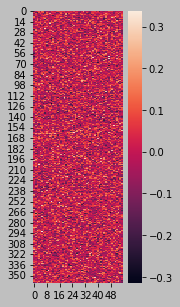

In [81]:
spectrogram(main_set[0])

In [82]:
train_len = int(len(main_set) * 0.8)
val_len = len(main_set) - train_len

train_set, valid_set = random_split(main_set, [train_len, val_len])

## Building models

In [83]:
progress = ProgressBar()
scheduler = LRScheduler(policy='CosineAnnealingLR', T_max=12, eta_min=1e-7)
roc = EpochScoring(make_scorer(roc_auc_score), name=f'roc_auc', lower_is_better=False, use_caching=True)
recall = EpochScoring(make_scorer(recall_score), name=f'recall', lower_is_better=False, use_caching=True)
precision = EpochScoring(make_scorer(precision_score), name=f'precision', lower_is_better=False, use_caching=True)
brier = EpochScoring(make_scorer(brier_score_loss), name=f'brier', lower_is_better=True, use_caching=True)

In [84]:
def build_net(model, val_set=predefined_split(valid_set), n_epochs=5, lr=1e-5, checkpoint_callback=None):
    net = NeuralNetClassifier(
                model,
                warm_start=True,
                max_epochs = n_epochs,
                batch_size = BATCH_SIZE,
                lr = lr,
                criterion = nn.CrossEntropyLoss(label_smoothing=0.3),
                optimizer = AdamW,
                optimizer__weight_decay = 1e-6,
                device = DEVICE,
                iterator_train__shuffle = True,
                iterator_train__num_workers = NUM_WORKERS,
                iterator_valid__num_workers = NUM_WORKERS,
                iterator_train__pin_memory = True,
                iterator_valid__pin_memory = True,
        
                train_split = val_set, 
        
                callbacks = [progress,
                             checkpoint_callback,
                             roc, recall, precision, brier,
                             LRScheduler(policy='CosineAnnealingLR',  T_max=25, eta_min=1e-7),
                            ],
    )
    return net

In [85]:
model1 = timm.create_model('eca_nfnet_l1', pretrained=False, num_classes=2, in_chans=1)
model2 = timm.create_model('nf_resnet50', pretrained=False, num_classes=2, in_chans=1)
model3 = timm.create_model('nfnet_l0', pretrained=False, num_classes=2, in_chans=1)

In [86]:
cp_net1 = Checkpoint(dirname='net1_checkpoint', load_best=True, monitor='valid_acc_best')
cp_net2 = Checkpoint(dirname='net2_checkpoint', load_best=True, monitor='valid_acc_best')
cp_net3 = Checkpoint(dirname='net3_checkpoint', load_best=True, monitor='valid_acc_best')

In [87]:
net1 = build_net(model1, val_set=predefined_split(valid_set), n_epochs=25, checkpoint_callback=cp_net1)
net2 = build_net(model2, val_set=predefined_split(valid_set), n_epochs=25, checkpoint_callback=cp_net2)
net3 = build_net(model3, val_set=predefined_split(valid_set), n_epochs=25, checkpoint_callback=cp_net3)

Those models were pretrained on ~6000 synthetic samples (NOT the provided train set). Due to the enourmous amount of disk space this takes, only the resulting weights are being loaded:

In [88]:
net1.initialize()
net1.load_params(f_params='/kaggle/input/gwnet-weights/net1.pkl')
net2.initialize()
net2.load_params(f_params='/kaggle/input/gwnet-weights/net2.pkl')
net3.initialize()
net3.load_params(f_params='/kaggle/input/gwnet-weights/net3.pkl')

## Synthetic models' evaluation against a provided train set

In [89]:
def calculate_metrics(probabilities, target_test):
    predictions = (probabilities > 0.5)
    f1 = f1_score(target_test, predictions)
    roc_auc = roc_auc_score(target_test, probabilities)
    acc = accuracy_score(target_test, predictions)
    ap = average_precision_score(target_test, probabilities)
    cmatrix = confusion_matrix(target_test, predictions)
    
    fpr, tpr, _ = roc_curve(target_test, probabilities)
    precision, recall, thresholds = precision_recall_curve(target_test, probabilities)
    f1_scores = 2 * recall * precision / (recall + precision)
    best_f1 = np.max(f1_scores)
    best_thresh = thresholds[np.argmax(f1_scores)]

    pred_t = (probabilities > best_thresh)
    best_cmatrix = confusion_matrix(target_test, pred_t)
    
    return f1, best_f1, roc_auc, acc, ap, best_thresh, fpr, tpr, recall, precision, cmatrix, best_cmatrix

def visualize_tests(probabilities, target_test):
    cmatrices = []

    fig, axes = plt.subplots(1, 2, figsize=(15,6))
    axes[0].plot([0, 1], linestyle='--')
    axes[1].plot([0.5, 0.5], linestyle='--')

    print('Processing validation set, please wait warmly...')
    f1, best_f1, roc_auc, acc, ap, best_thresh, fpr, tpr, recall, precision, cmatrix, best_cmatrix = calculate_metrics (probabilities, target_test)
    axes[0].plot (fpr, tpr);
    axes[1].plot (recall, precision);
    print (f'F1: {f1:.2f} (max: {best_f1:.2f} at {best_thresh:.2f} threshold), ROC_AUC: {roc_auc:.3f}, accuracy: {acc:.0%}, AP (PR_AUC): {ap:.2f}')
    cmatrices.append(cmatrix)
    cmatrices.append(best_cmatrix)
    
    axes[0].set (xlabel='FPR', ylabel='TPR', title='ROC curve', xlim=(0,1), ylim=(0,1))
    axes[1].set (xlabel='Recall', ylabel='Precision', title='PR curve', xlim=(0,1), ylim=(0,1))
    
    
    fig, axes = plt.subplots(1, 2, figsize=(13, 5), constrained_layout=True)
    for cmatrix, ax, title in zip(cmatrices, axes.flat, ['Confusion Maxtrix', 'Confusion Maxtrix (optimal F1 threshold)']):
        sns.heatmap(cmatrix, ax=ax, annot=True, cmap='Blues', fmt='d').set(title=title, xlabel='Prediction', ylabel='Reality')
    
    
    return best_thresh

In [90]:
target_valid = [l[1] for l in valid_set]

In [91]:
target_train = [l[1] for l in train_set]

In [92]:
probabilities1 = net1.predict_proba(train_set)[:, 1]
probabilities2 = net2.predict_proba(train_set)[:, 1]
probabilities3 = net3.predict_proba(train_set)[:, 1]

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Processing validation set, please wait warmly...
F1: 0.76 (max: 0.81 at 0.41 threshold), ROC_AUC: 0.801, accuracy: 73%, AP (PR_AUC): 0.91


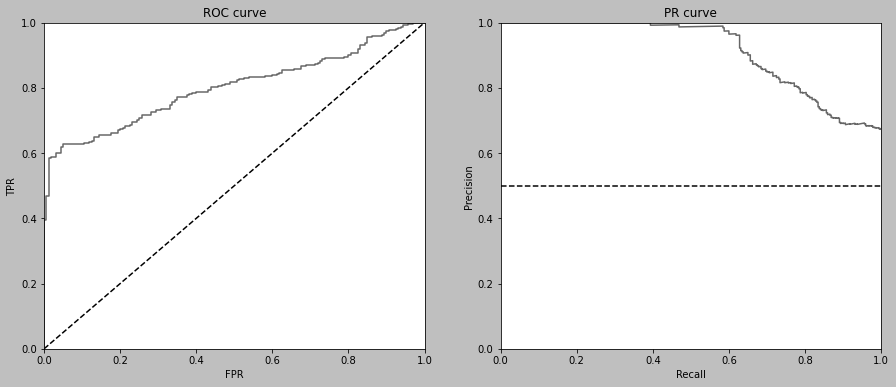

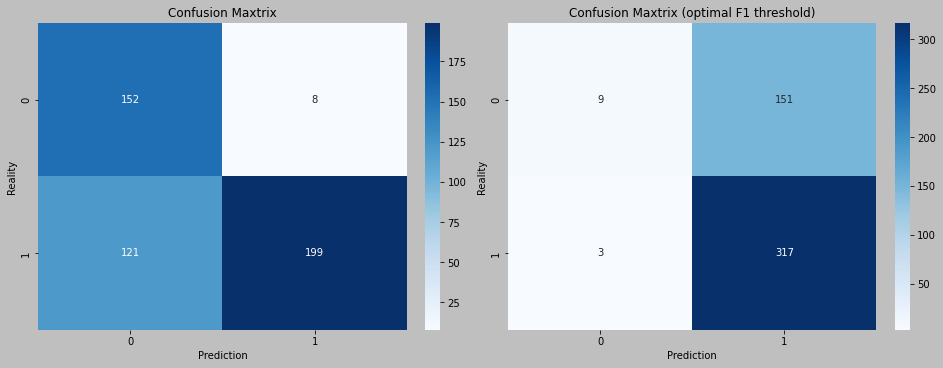

In [93]:
best_threshold1 = visualize_tests(probabilities1, target_train)

Processing validation set, please wait warmly...
F1: 0.77 (max: 0.80 at 0.43 threshold), ROC_AUC: 0.809, accuracy: 73%, AP (PR_AUC): 0.92


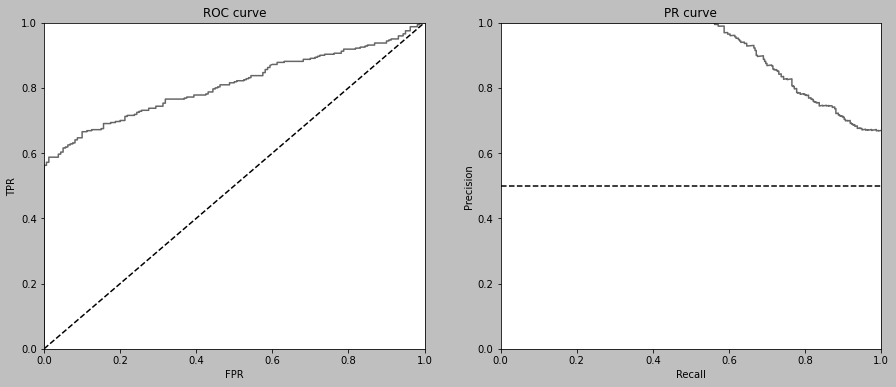

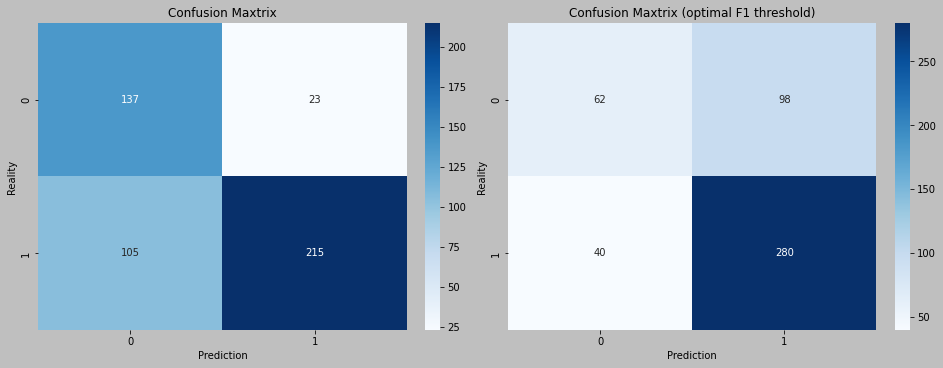

In [94]:
best_threshold2 = visualize_tests(probabilities2, target_train)

Processing validation set, please wait warmly...
F1: 0.77 (max: 0.81 at 0.44 threshold), ROC_AUC: 0.820, accuracy: 74%, AP (PR_AUC): 0.92


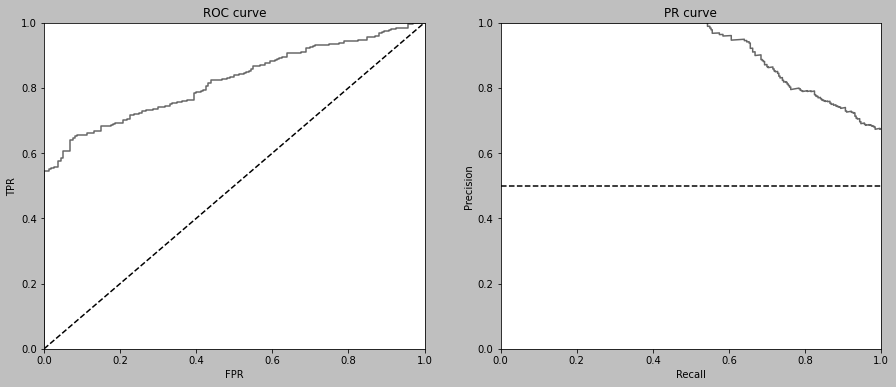

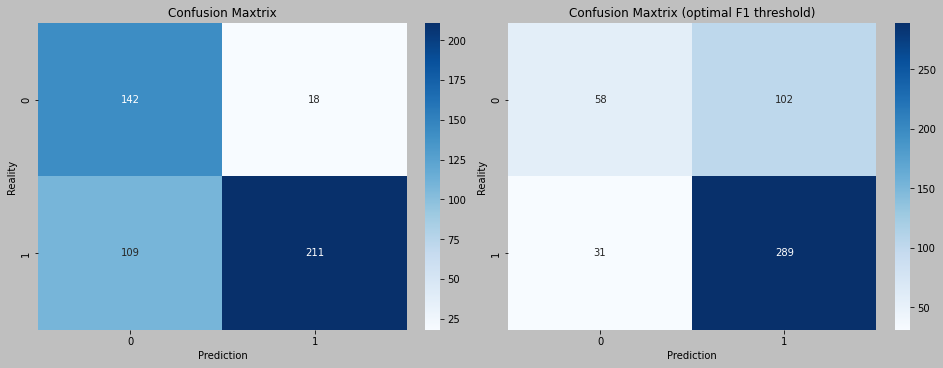

In [95]:
best_threshold3 = visualize_tests(probabilities3, target_train)

The result is not so bad, yielding around 0.8 ROC_AUC.

## Ensembling

Intead of fine-tuning on the initial train set, we'll adjust the synthetic models' bias using logistic regression of their scores on the train set against the target:

In [ ]:
target_train = [l[1] for l in main_set]
probabilities1 = net1.predict_proba(main_set)[:, 1]
probabilities2 = net2.predict_proba(main_set)[:, 1]
probabilities3 = net3.predict_proba(main_set)[:, 1]

In [96]:
def fit_ensemble():
    meta_X = list()
    meta_X.append(probabilities1.reshape(-1, 1))
    meta_X.append(probabilities2.reshape(-1, 1))
    meta_X.append(probabilities3.reshape(-1, 1))
    meta_X = np.hstack(meta_X)
    blender = LogisticRegression(random_state=RANDOM_STATE, n_jobs=-1)
    blender.fit(meta_X, target_train)
    return blender

def predict_ensemble(blender, features):
    meta_X = list()
    meta_X.append(net1.predict_proba(features)[:, 1].reshape(-1, 1))
    meta_X.append(net2.predict_proba(features)[:, 1].reshape(-1, 1))
    meta_X.append(net3.predict_proba(features)[:, 1].reshape(-1, 1))
    meta_X = np.hstack(meta_X)
    return blender.predict_proba(meta_X)

In [97]:
blender = fit_ensemble()

In [100]:
predictions = predict_ensemble(blender, test_set)

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [101]:
test_results = pd.DataFrame(data = {'id': test_set.files, 'target': predictions[:,1]}).set_index('id')

In [102]:
test_results.to_csv('submission.csv')

This results in about 0.7 ROC_AUC on the public test set.